In [143]:
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs("figs/", exist_ok=True)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.rcParams['mathtext.fontset'] = 'stix'  # The setting of math font

In [144]:
config_table = pd.read_csv("results/setting-table.csv", index_col=0)
mean_vals = pd.read_csv("results/mean_vals.csv")
OPTUNA_INDEX = [60, 108]
optuna_vals = mean_vals[np.any([mean_vals.setting_index == idx for idx in OPTUNA_INDEX], axis=0)]
mean_vals = mean_vals[np.all([mean_vals.setting_index != idx for idx in OPTUNA_INDEX], axis=0)]

target_names = mean_vals.target.unique()
target_cols = mean_vals.target
target_names

array(['fashion_mnist', 'cifar10', 'XinSheYang_05d', 'Styblinski_05d',
       'Ackley_05d', 'Schwefel_30d', 'Schwefel_10d', 'Rosenbrock_30d',
       'KTablet_30d', 'Ackley_30d', 'Griewank_10d', 'Ackley_10d',
       'Rastrigin_30d', 'Sphere_10d', 'Schwefel_05d', 'Griewank_05d',
       'WeightedSphere_30d', 'WeightedSphere_05d', 'KTablet_10d',
       'XinSheYang_30d', 'Rosenbrock_10d', 'Levy_30d', 'Sphere_30d',
       'Levy_10d', 'Perm_30d', 'Sphere_05d', 'KTablet_05d',
       'WeightedSphere_10d', 'Rastrigin_05d', 'XinSheYang_10d',
       'Rastrigin_10d', 'Rosenbrock_05d', 'Styblinski_30d', 'Perm_10d',
       'Perm_05d', 'Styblinski_10d', 'Levy_05d', 'Griewank_30d',
       'vehicle', 'parkinsons_telemonitoring', 'protein_structure',
       'segment', 'car', 'australian', 'credit_g', 'naval_propulsion',
       'blood_transfusion', 'kc1', 'phoneme', 'slice_localization'],
      dtype=object)

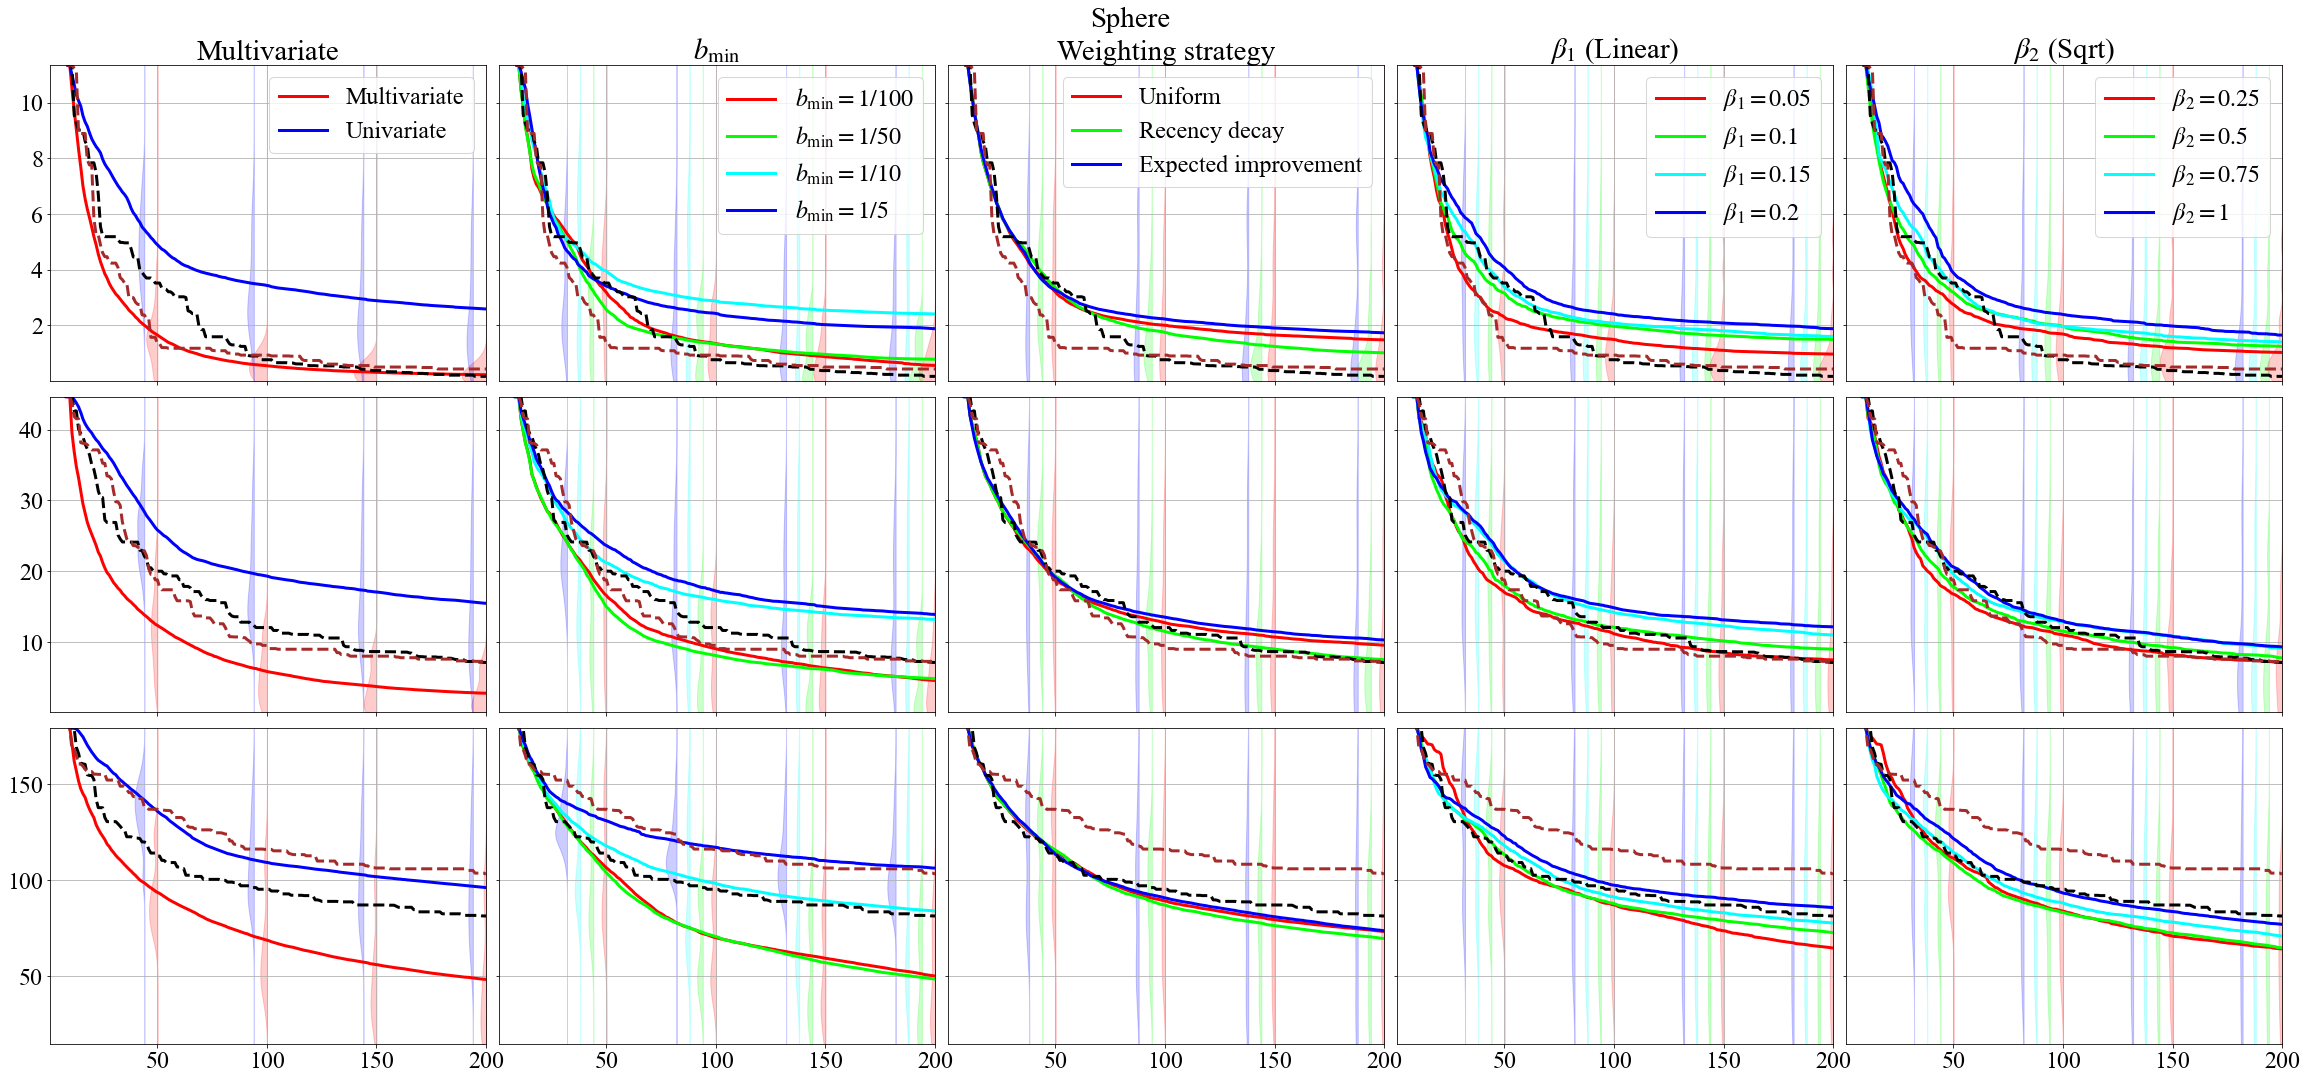

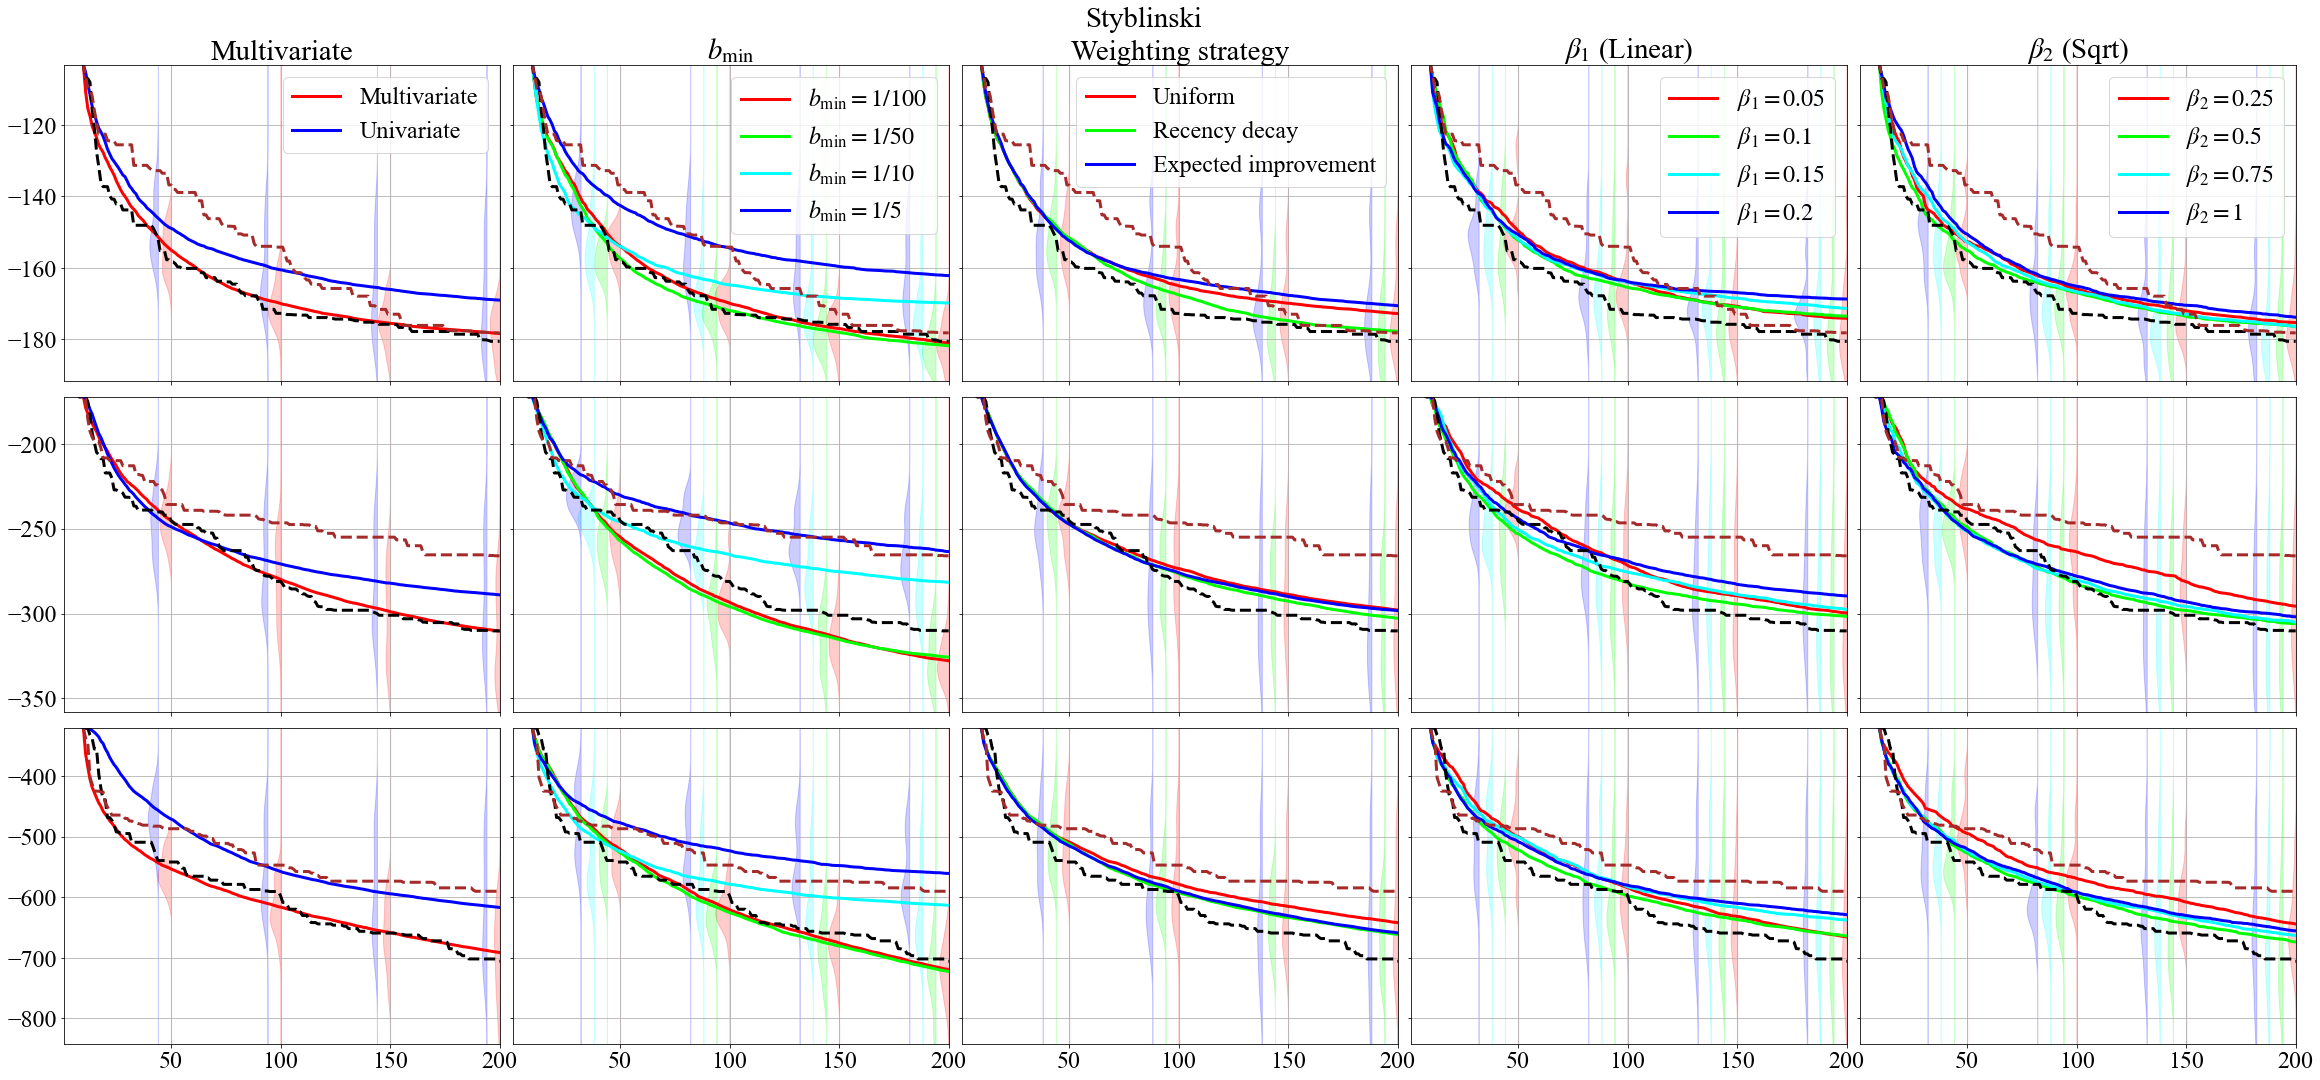

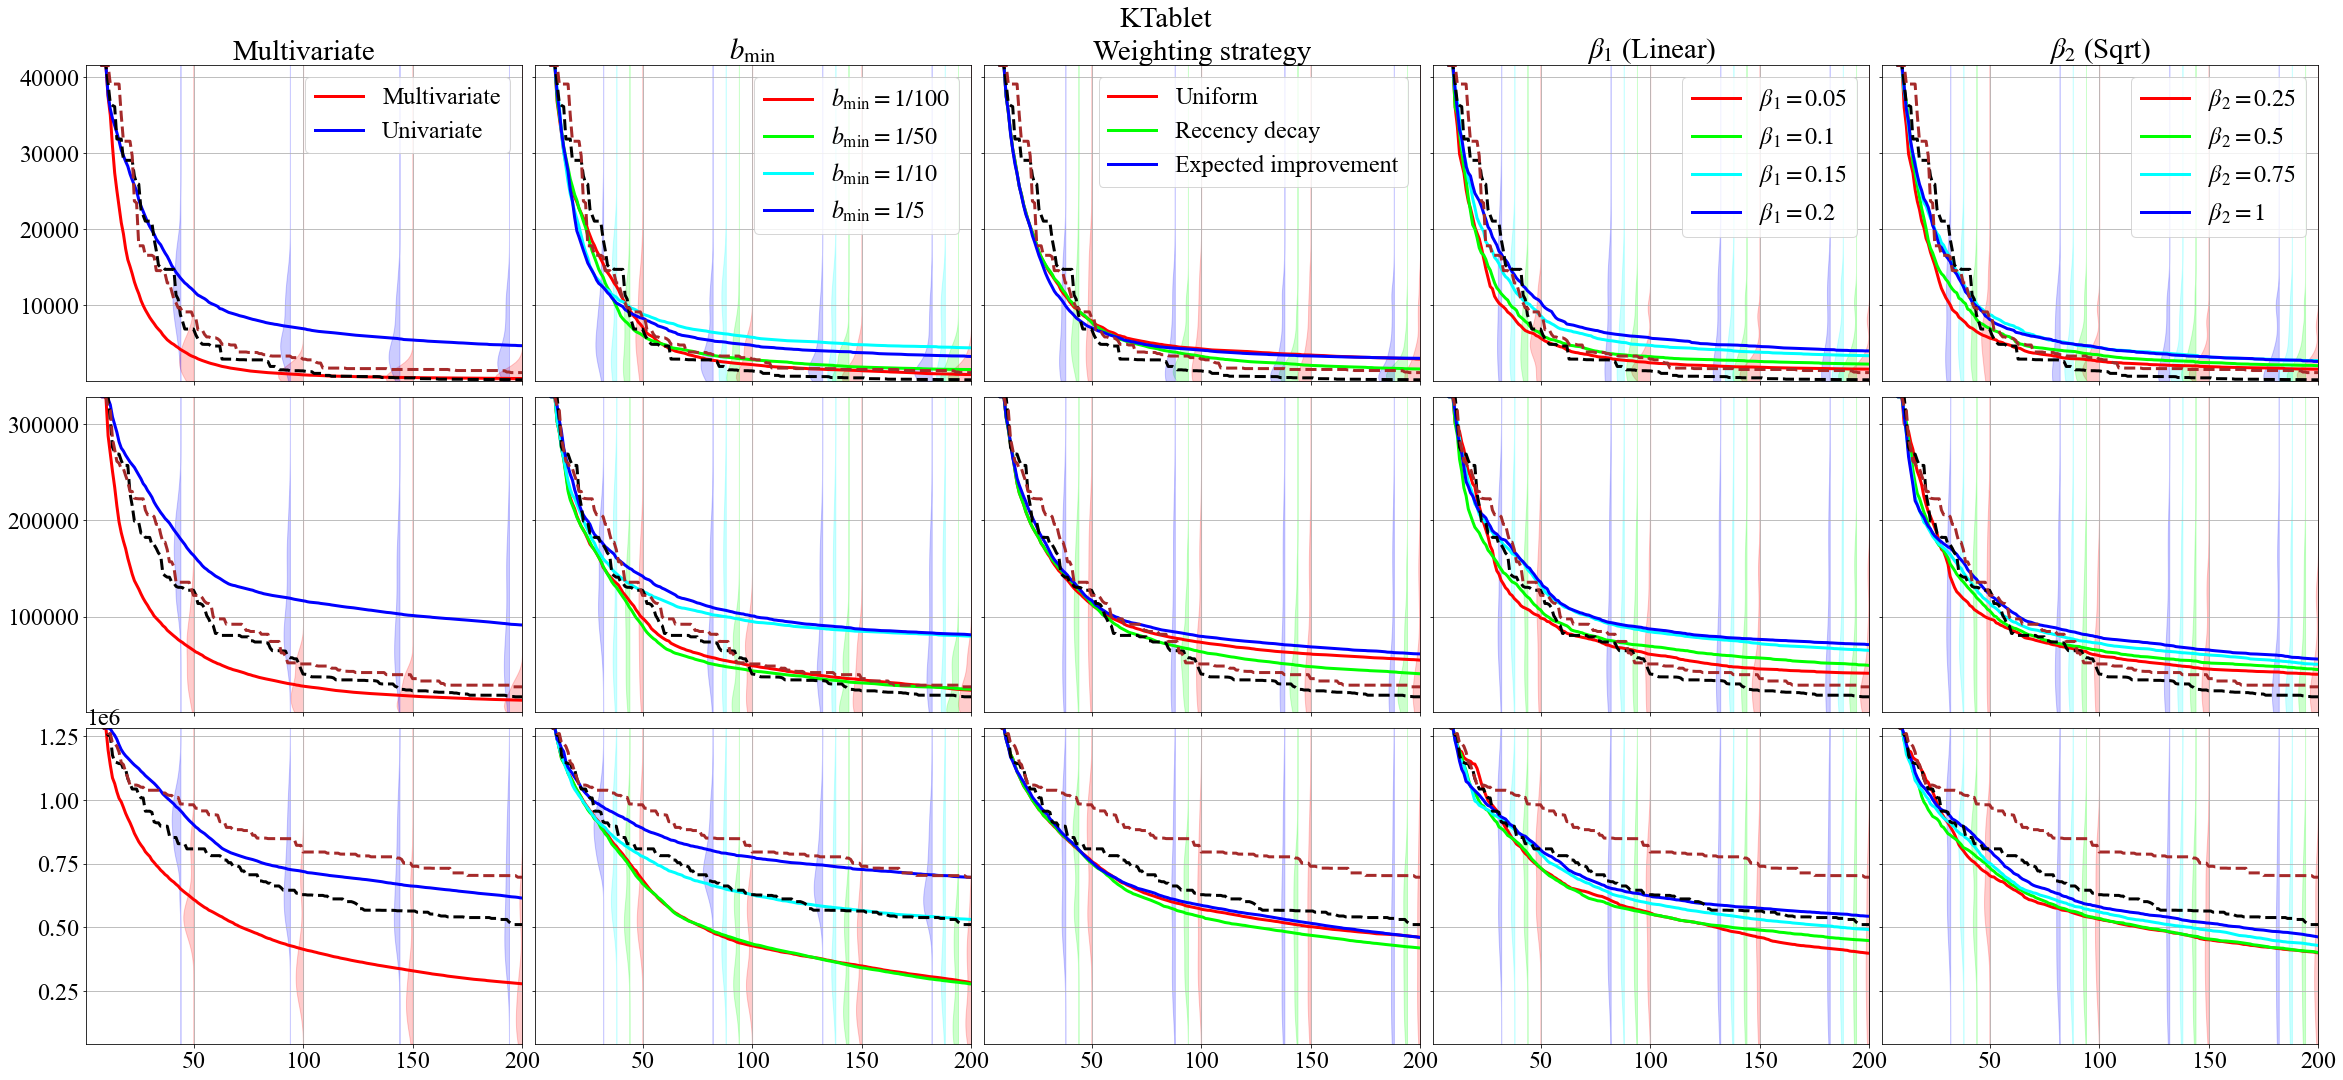

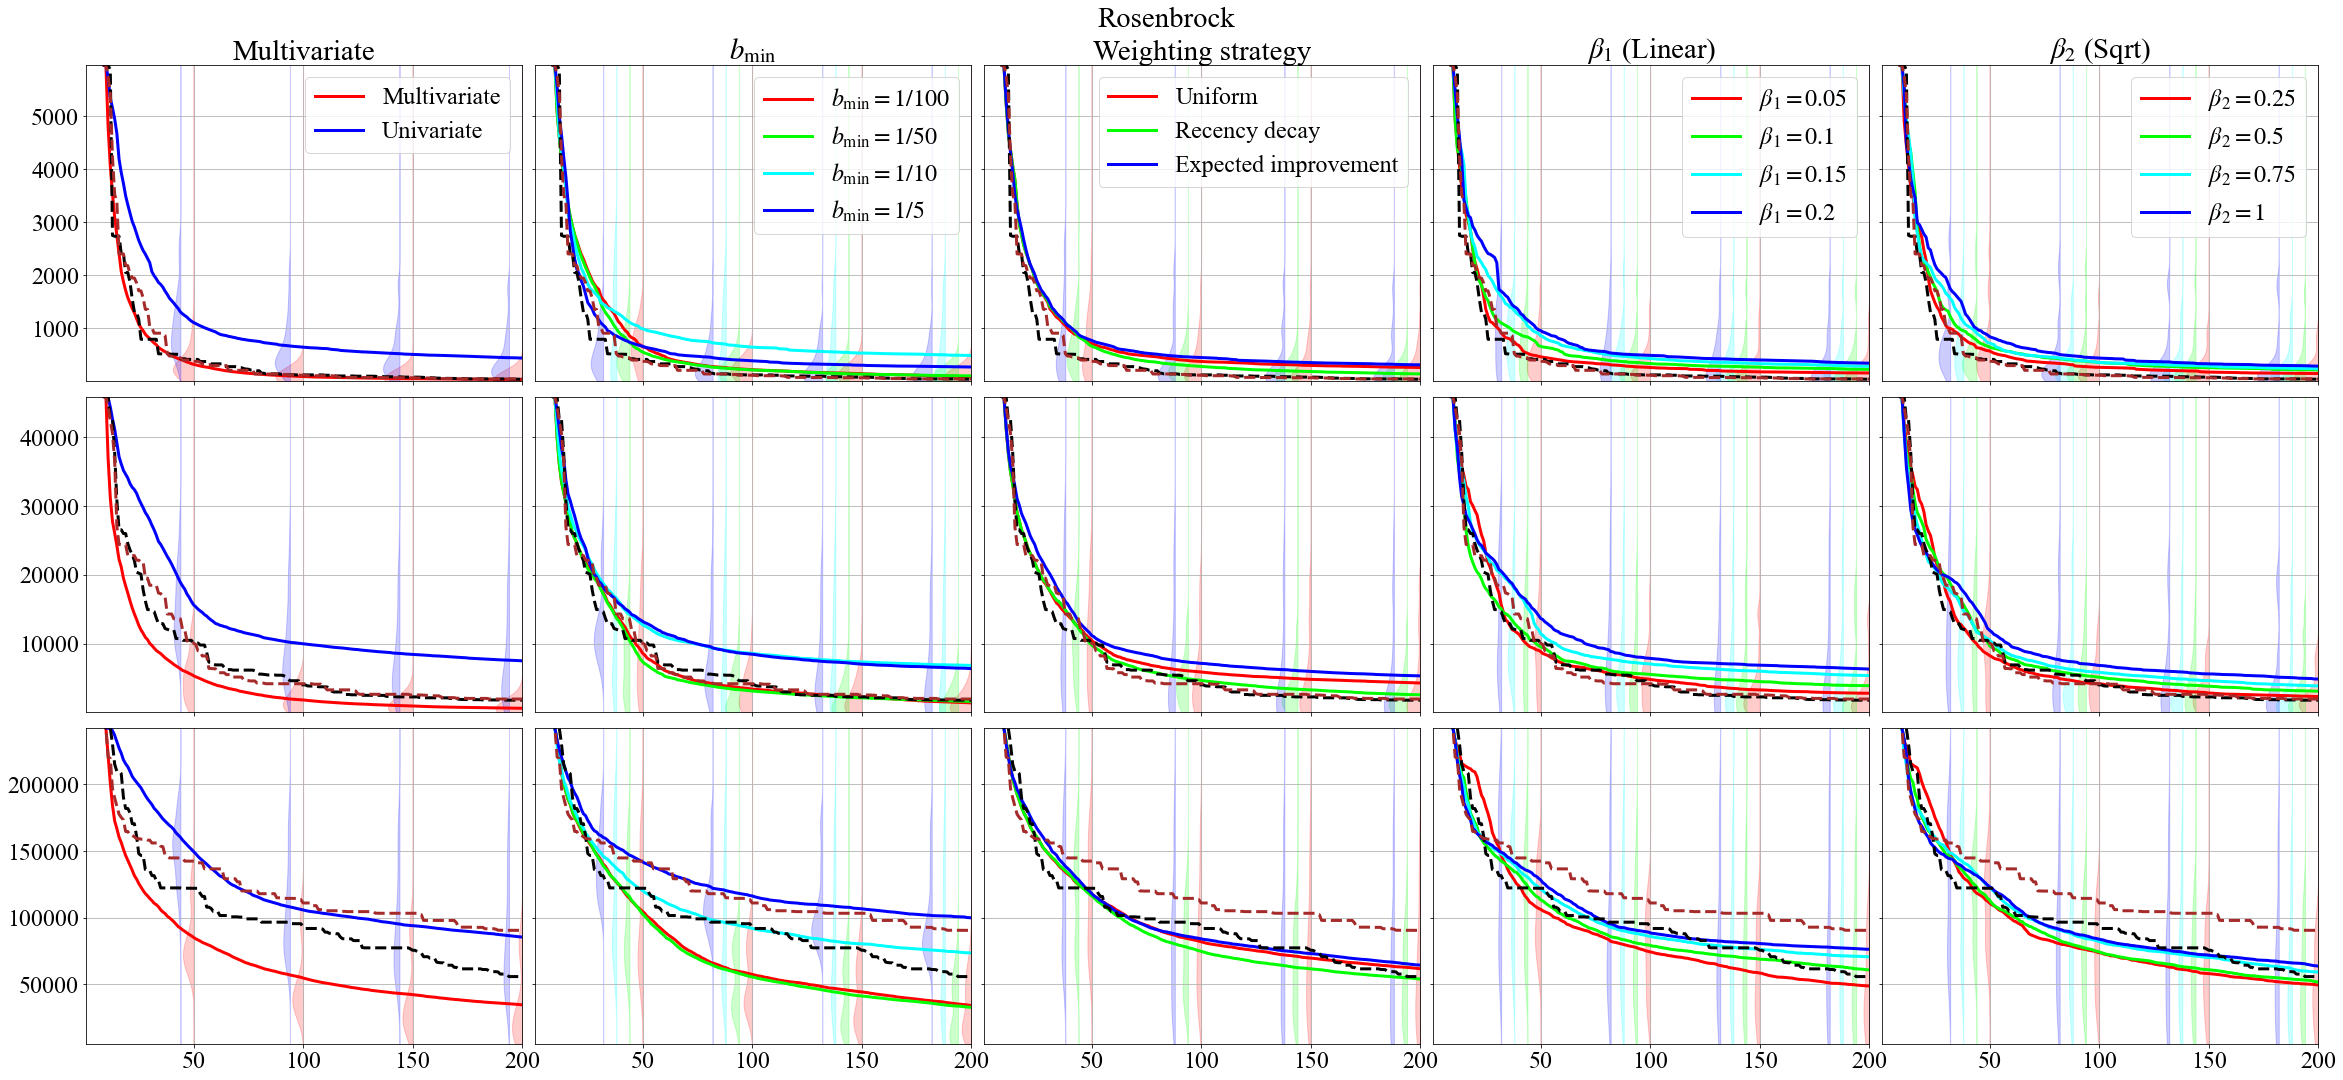

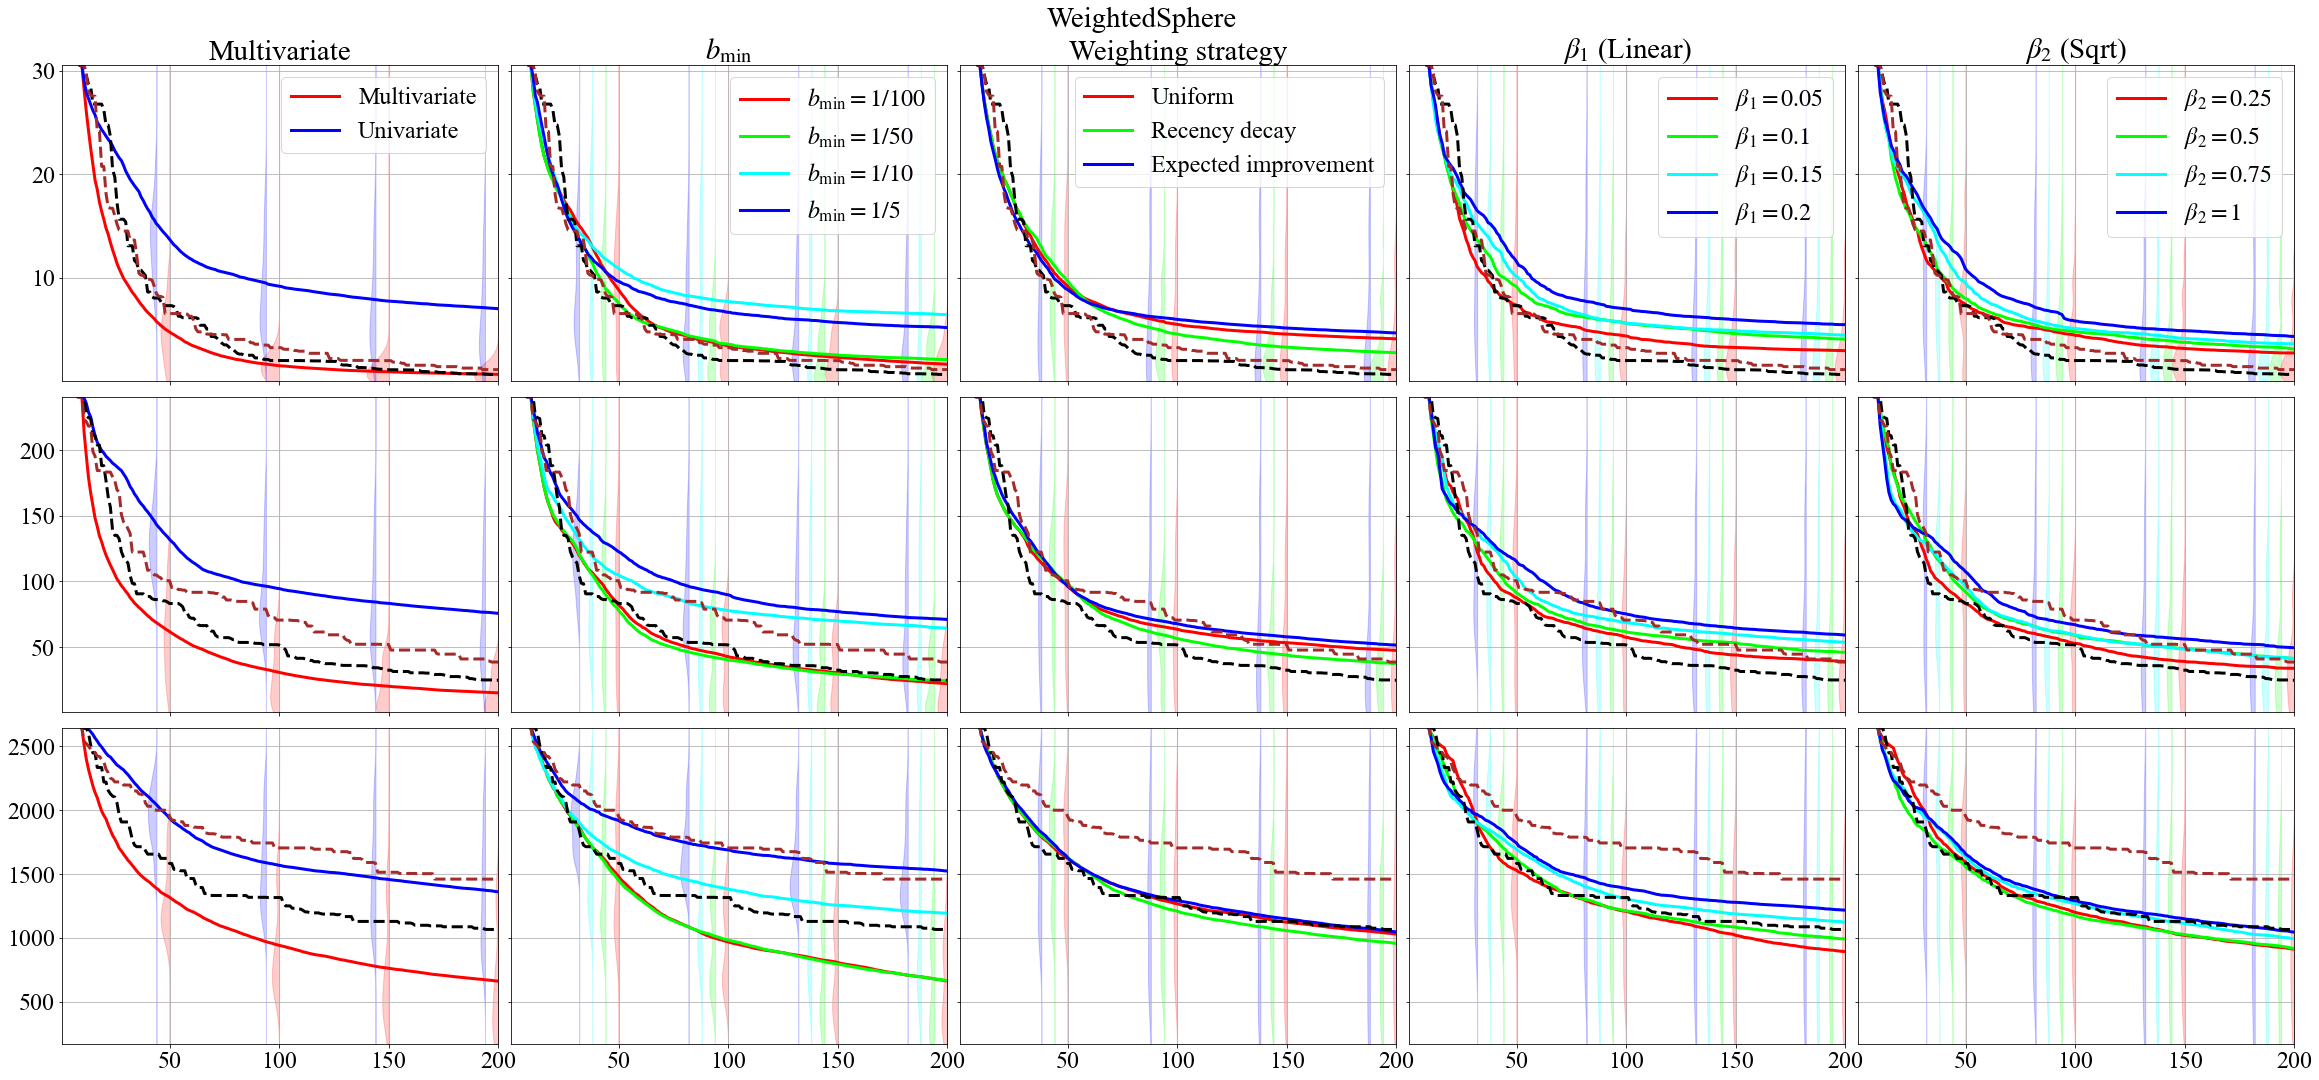

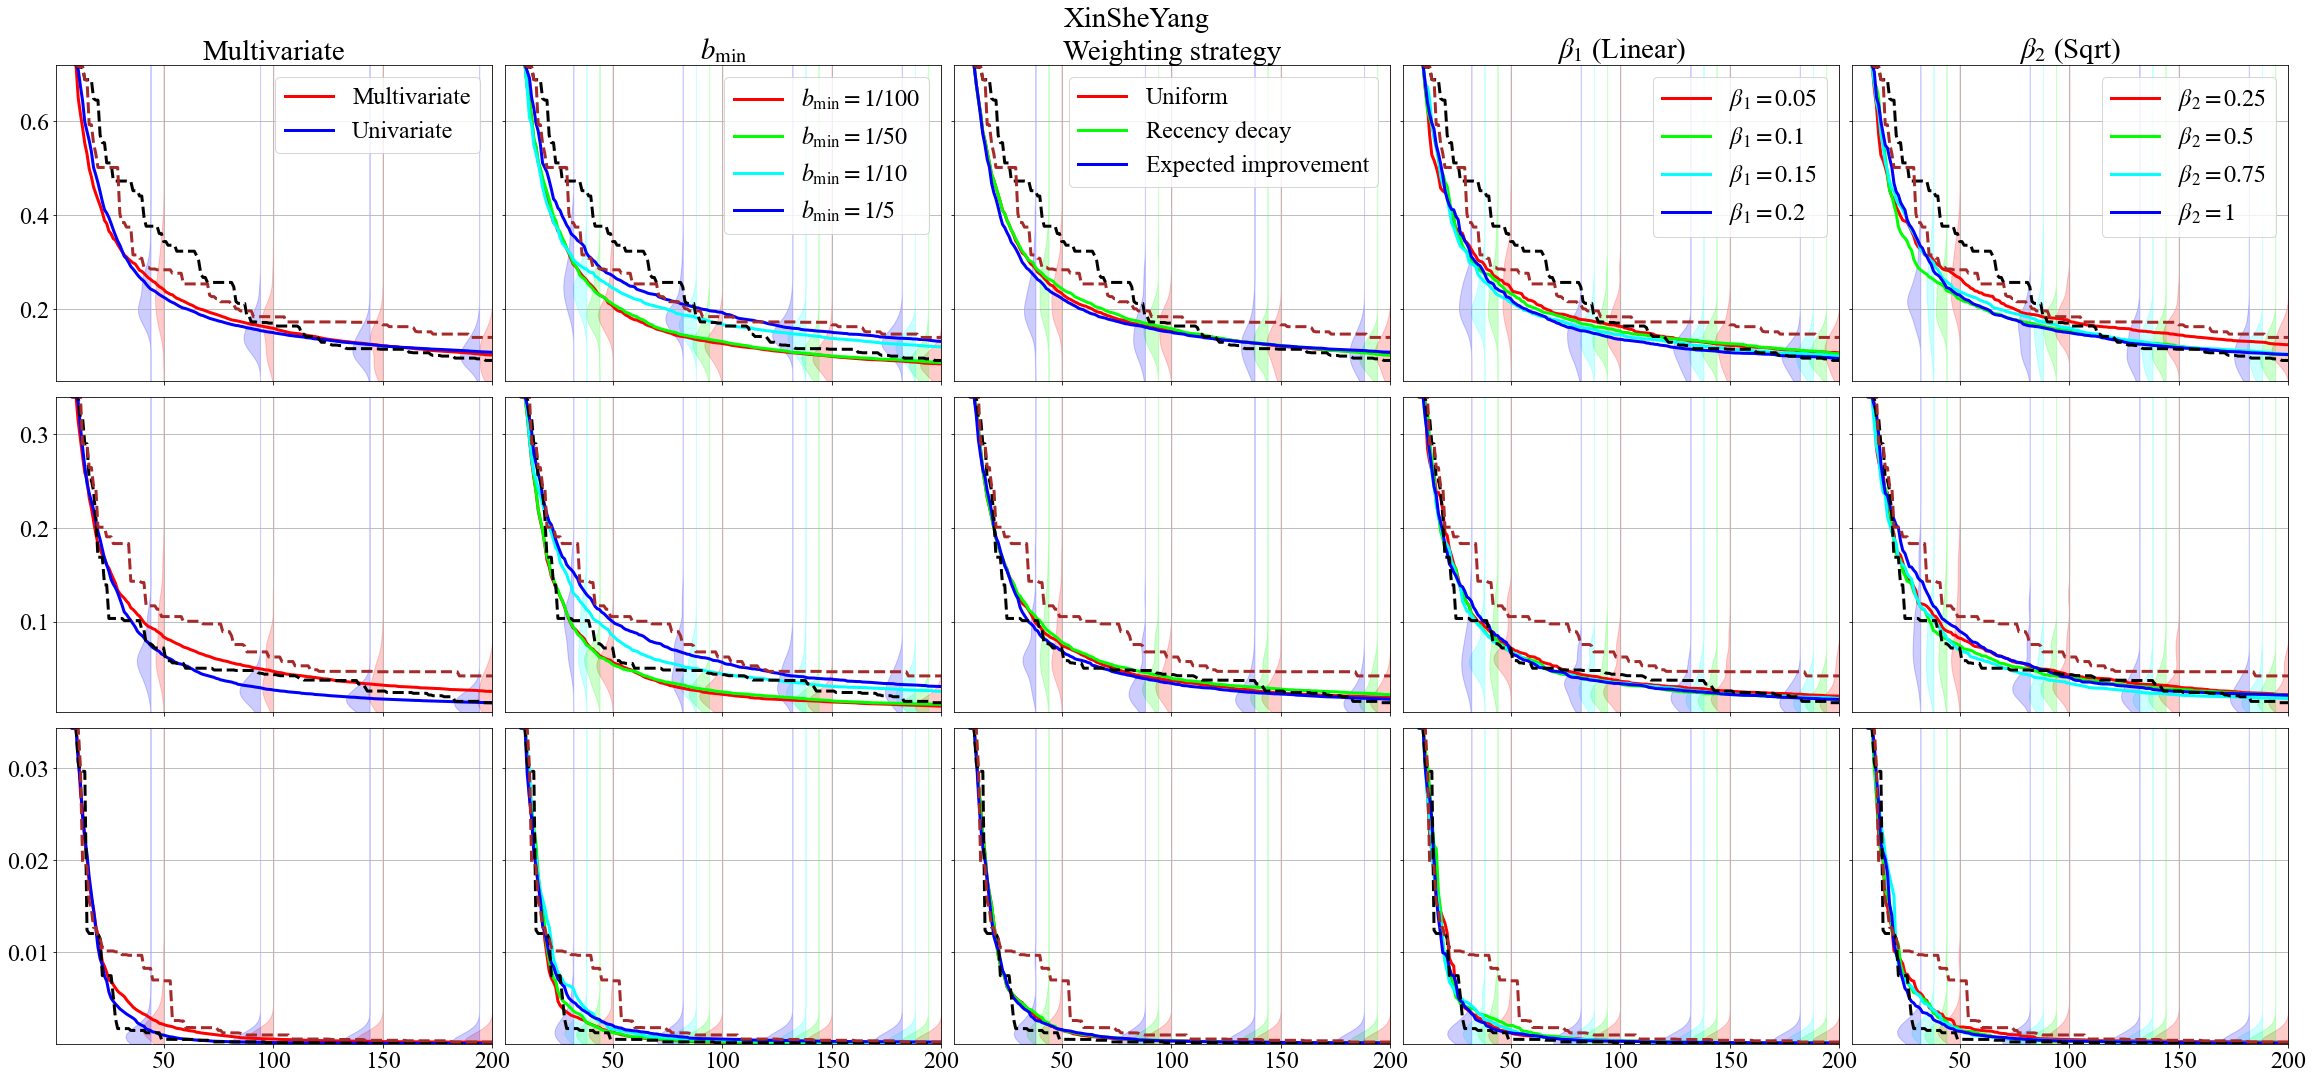

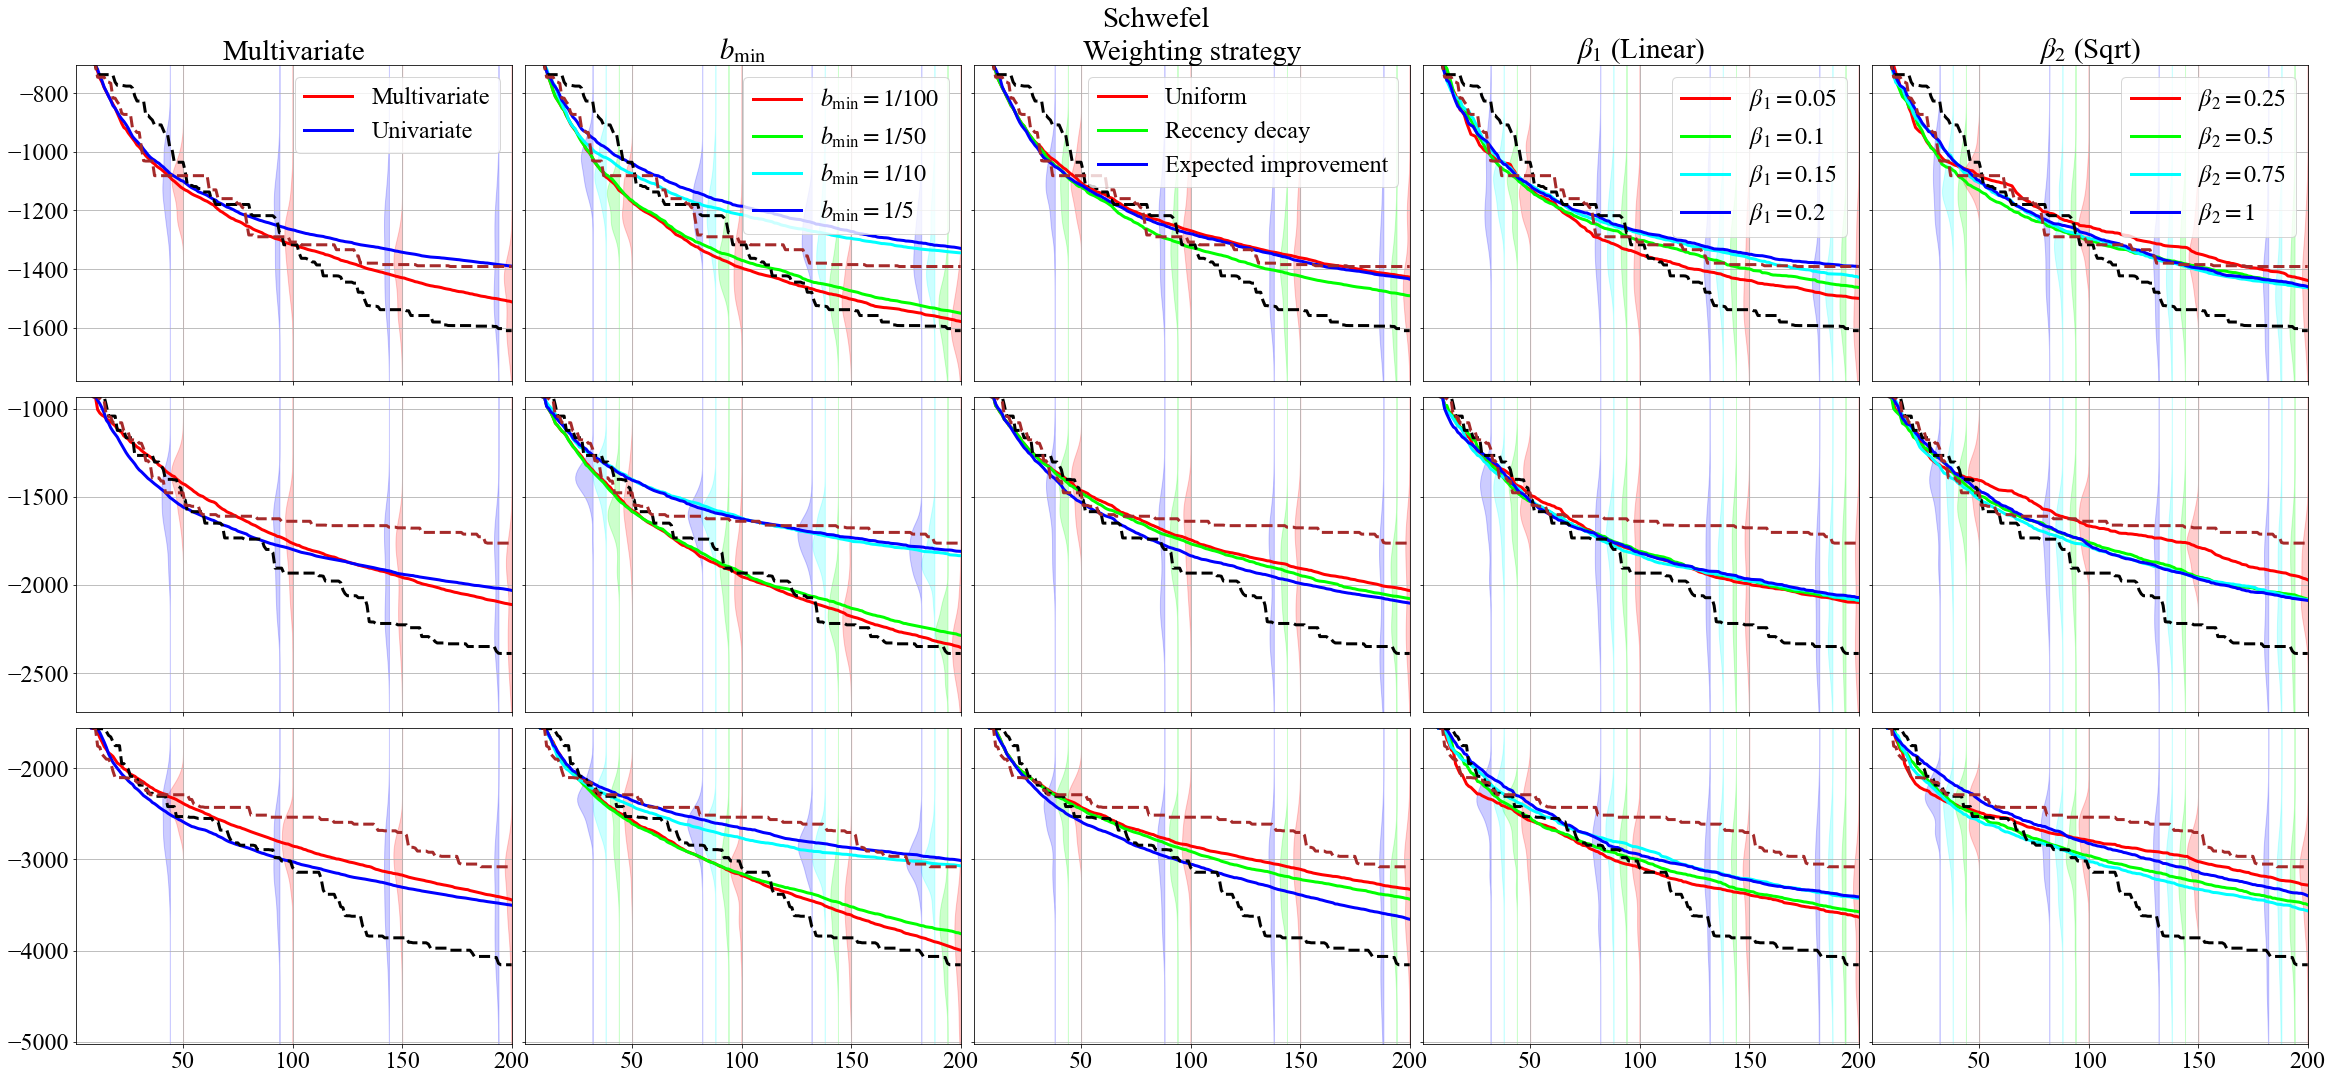

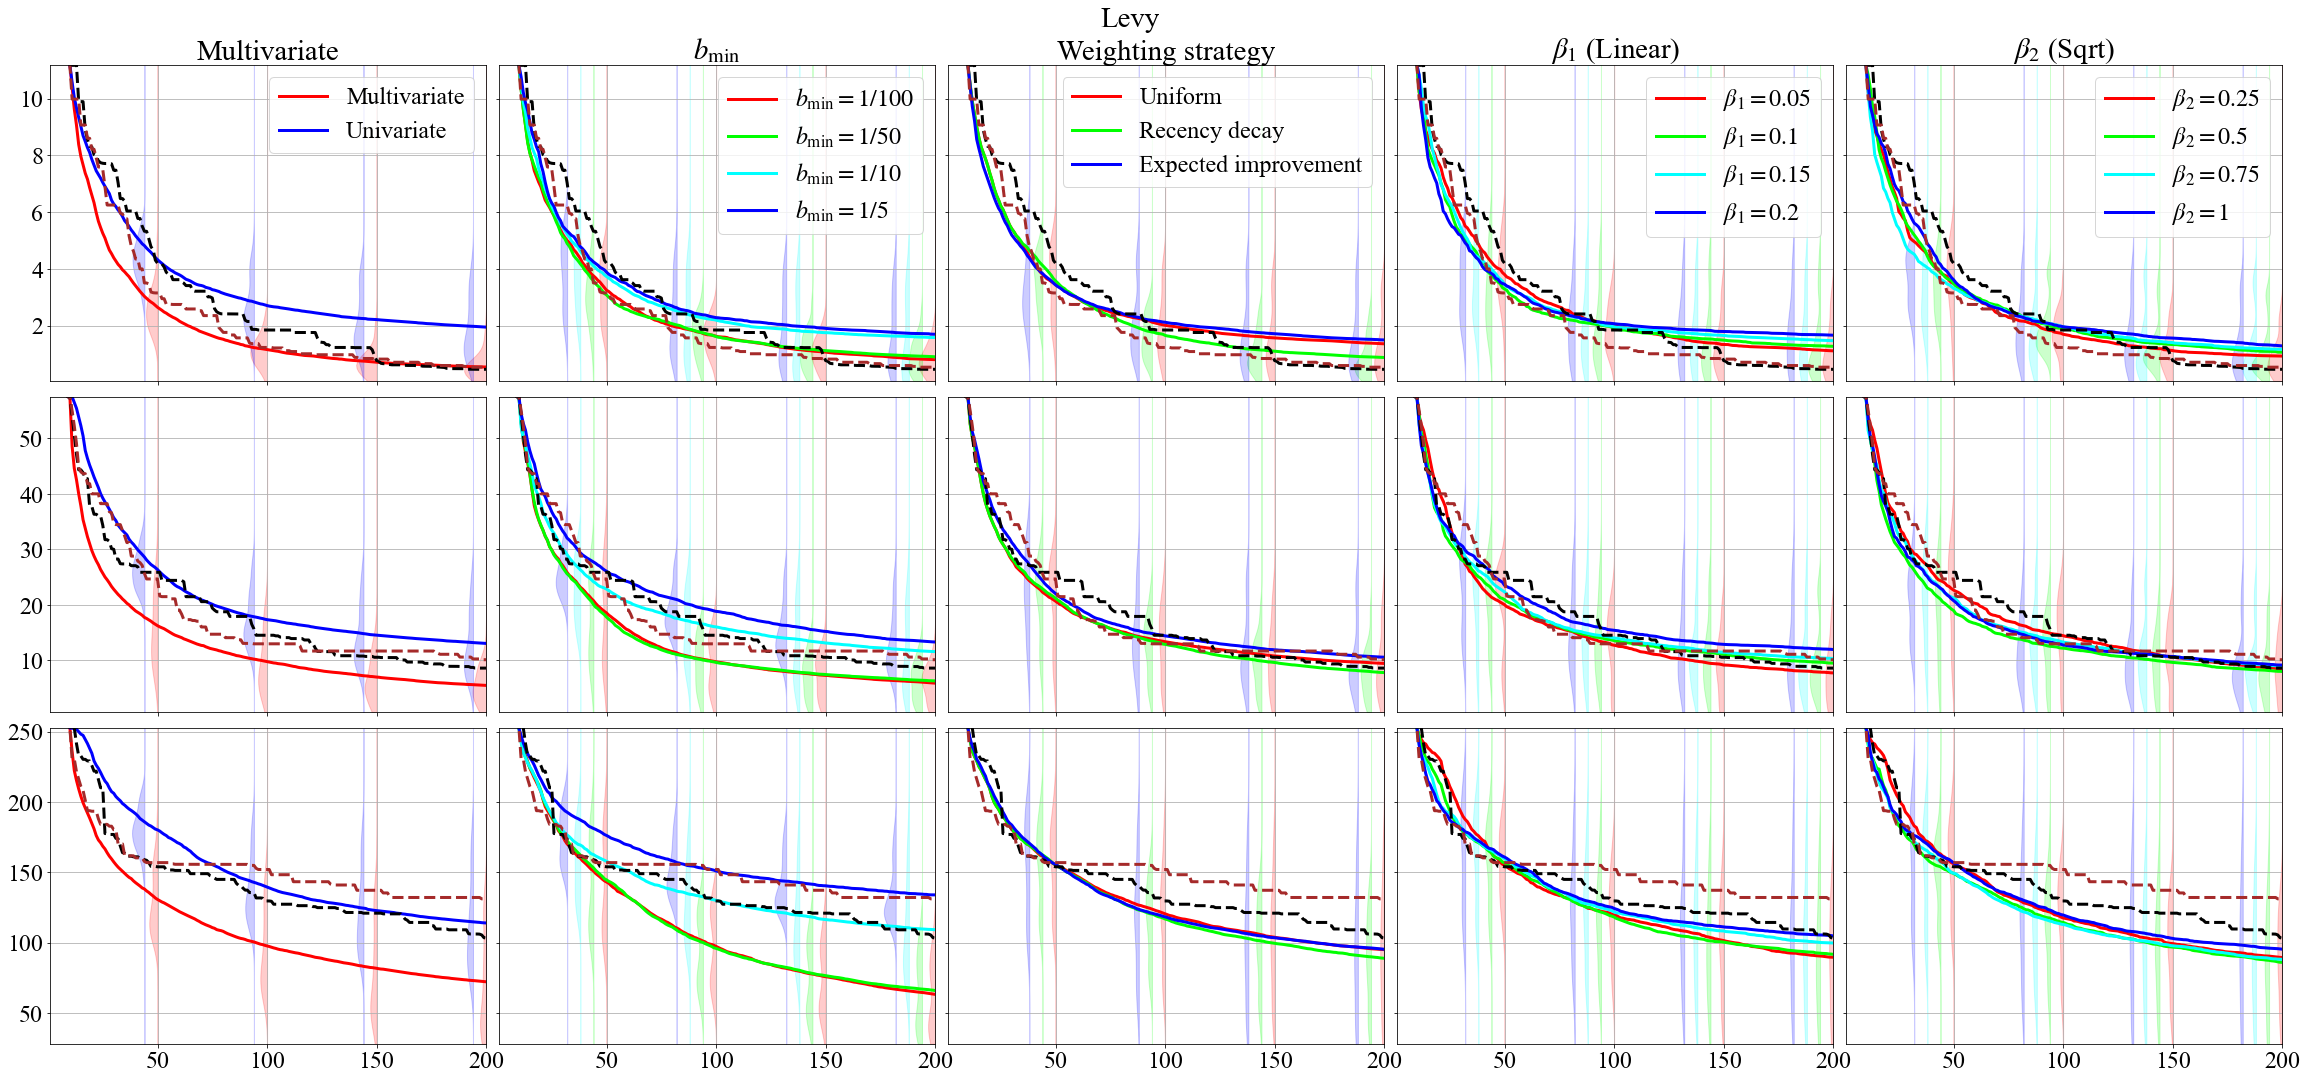

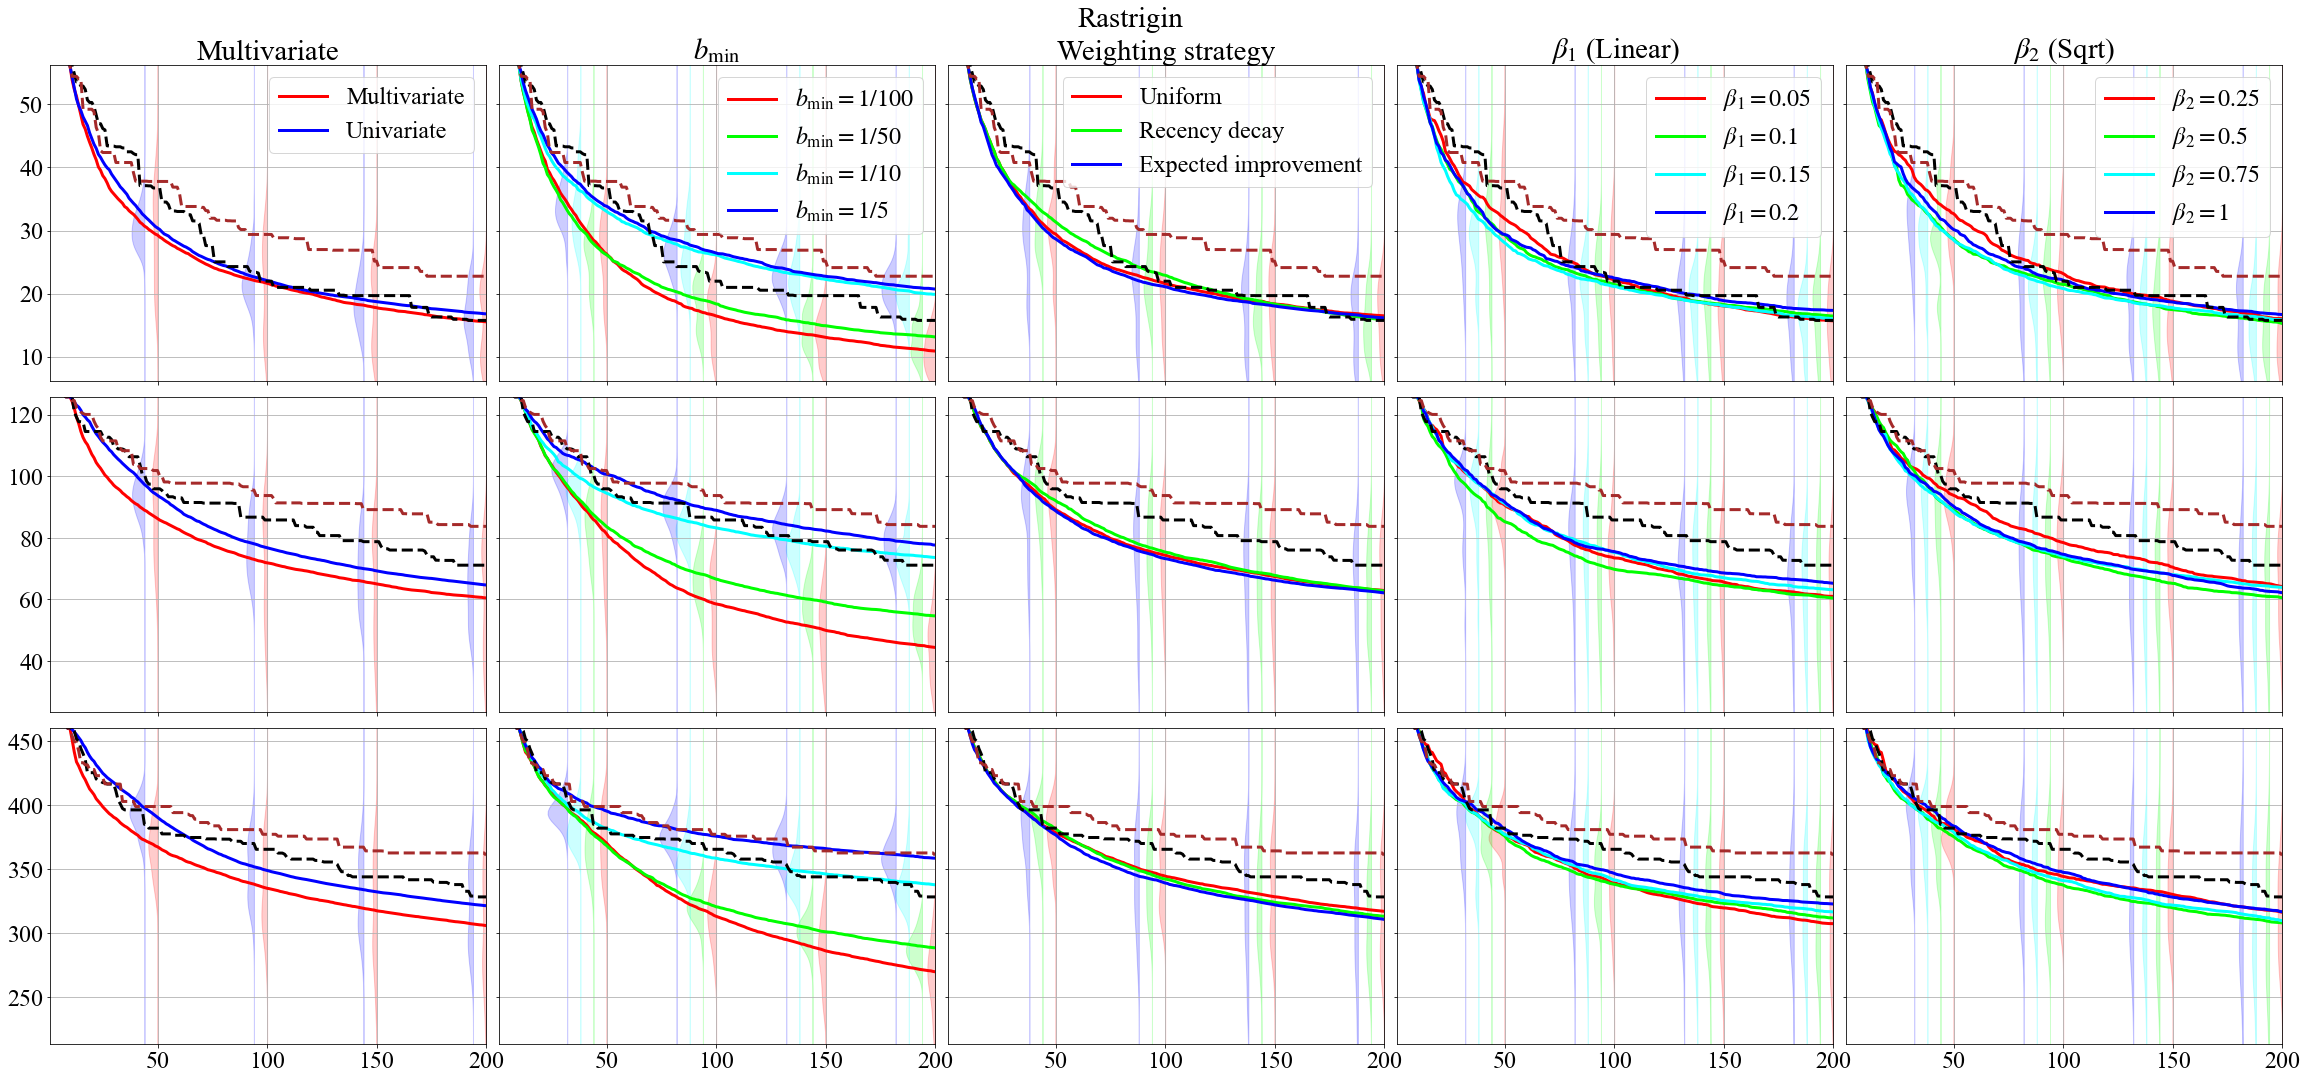

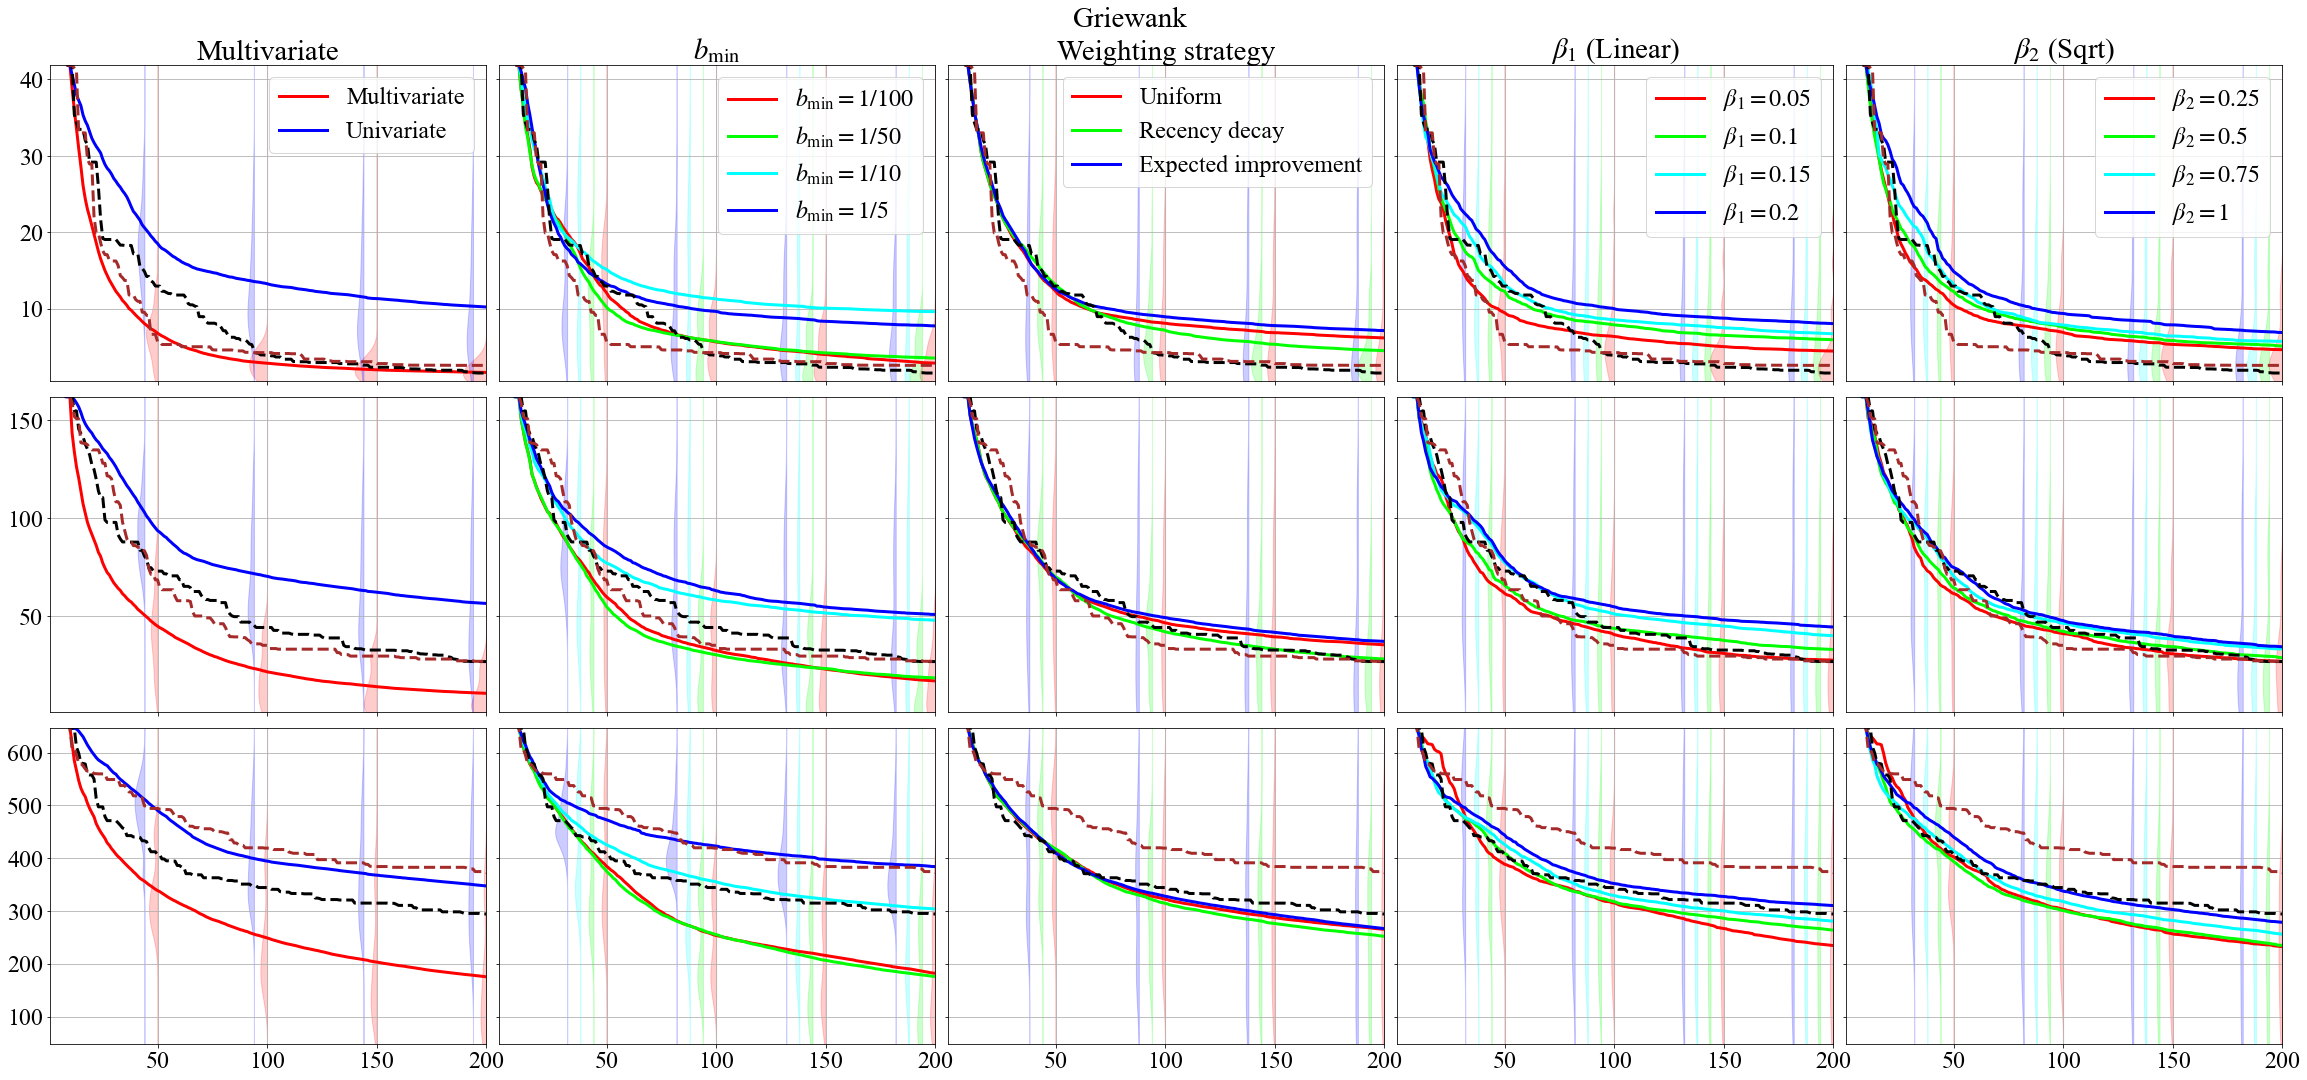

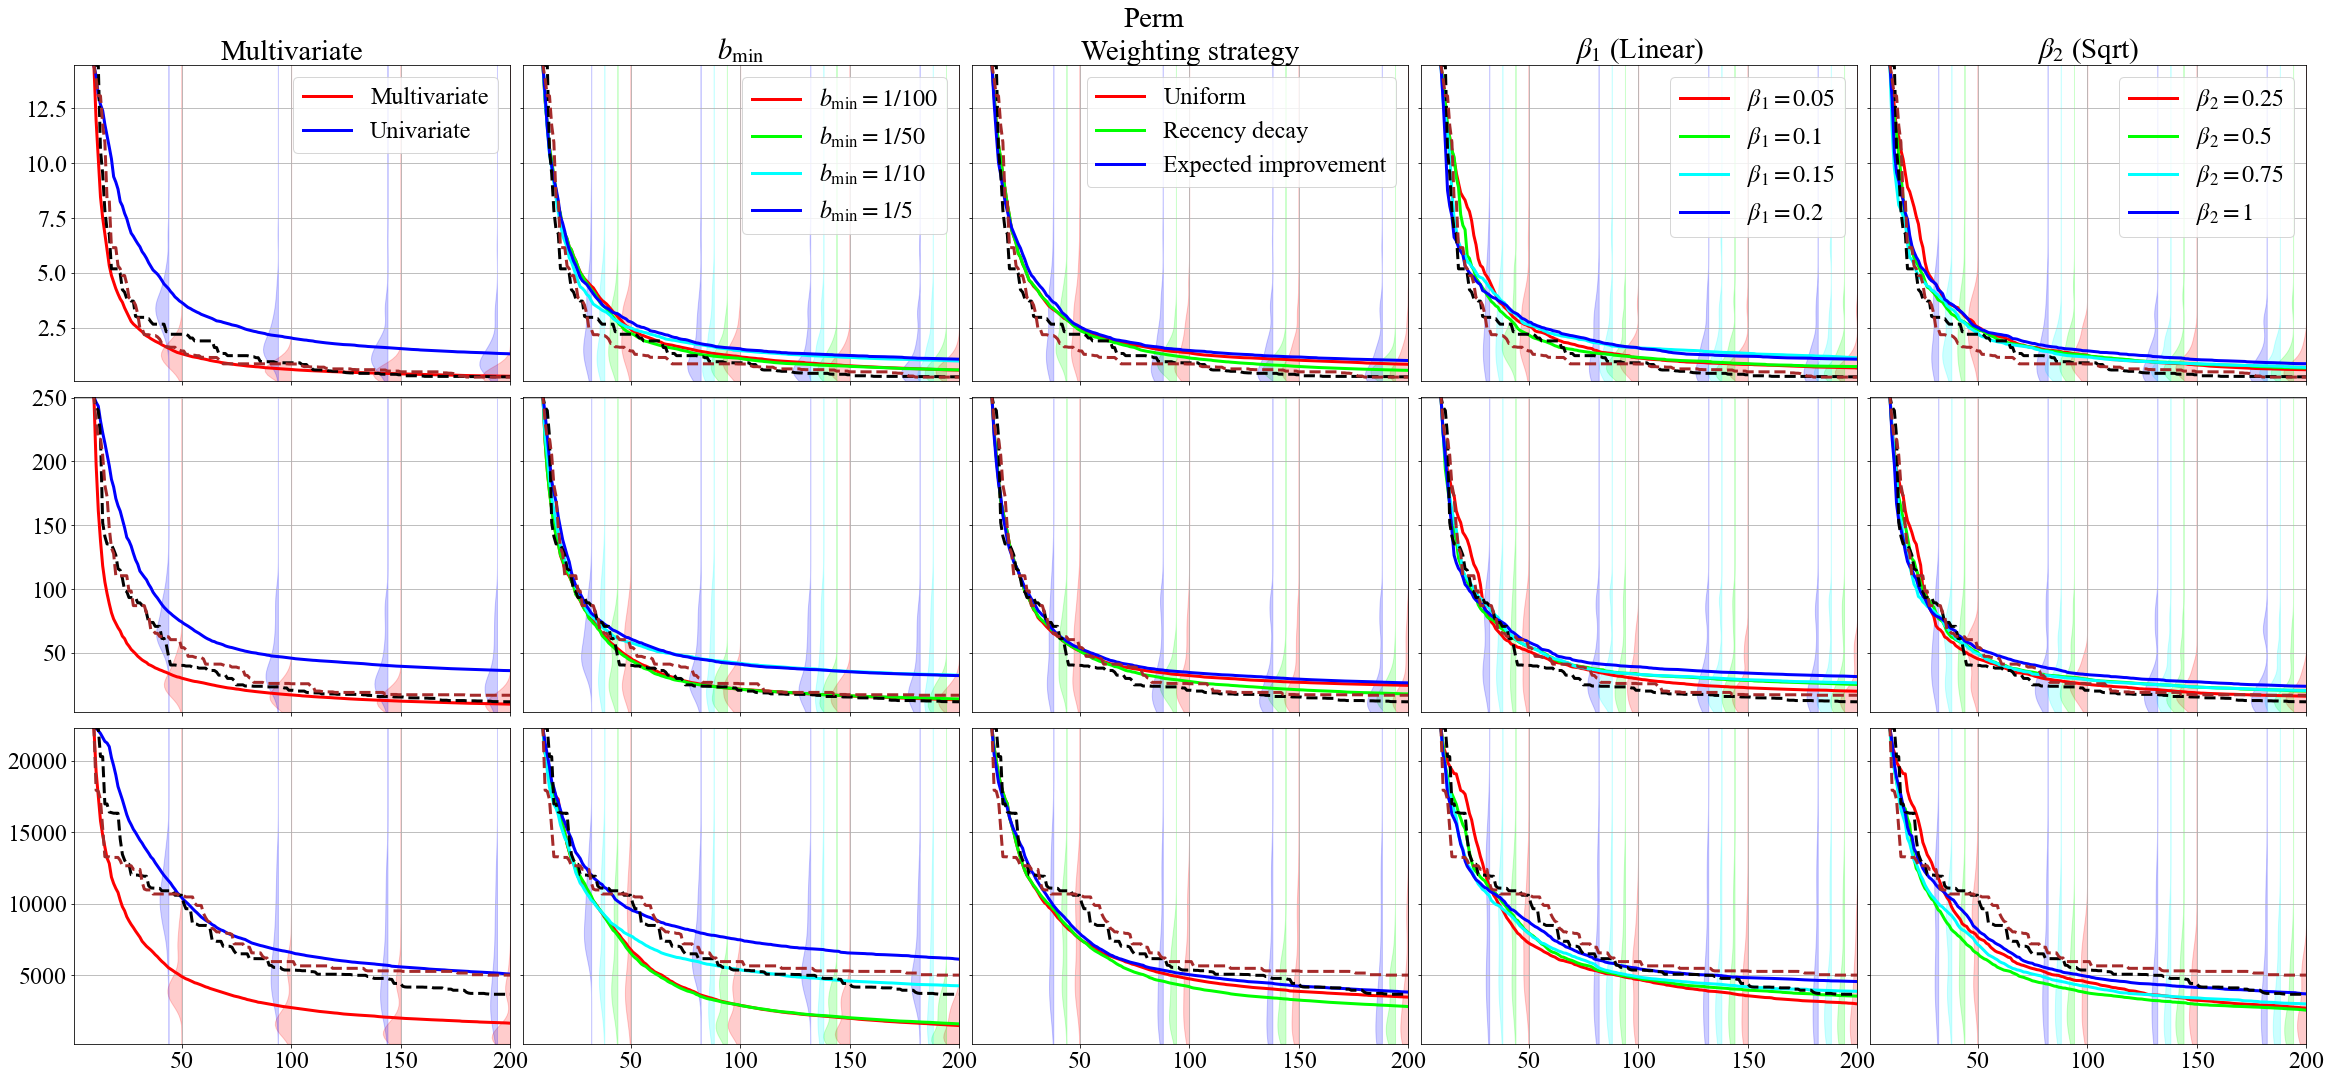

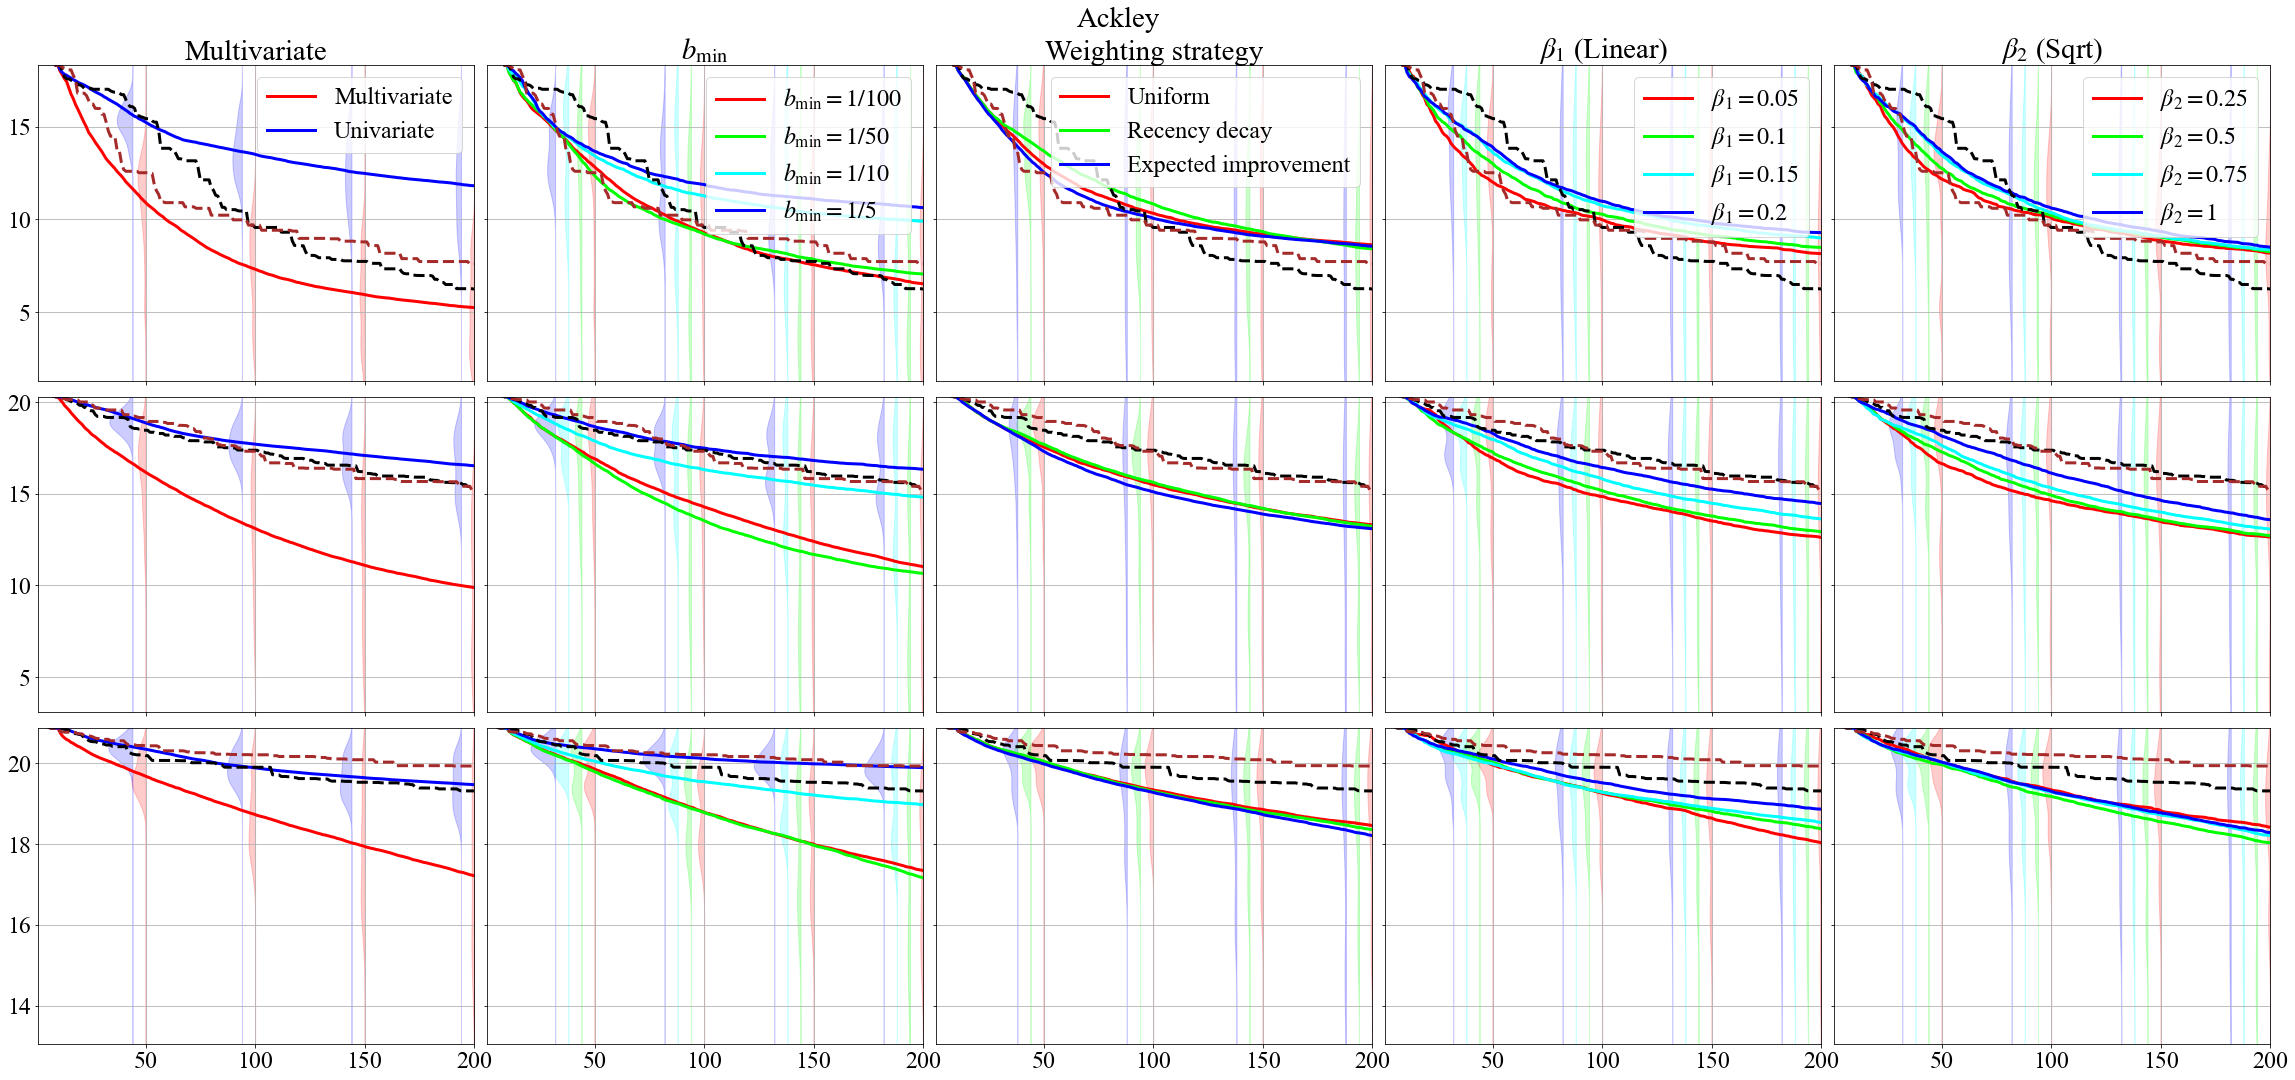

In [205]:
from typing import Optional, Tuple
from parzen_estimator import NumericalParzenEstimator


def plot_pdp(
    ax: plt.Axes,
    target_name: str,
    masks: Tuple[np.ndarray],
    colors: Tuple[str],
    title: Optional[str],
    labels: Optional[Tuple[str]],
):
    target_mean = mean_vals[target_cols == target_name]
    optuna_means = optuna_vals[optuna_vals.target == target_name]
    X = np.arange(200) + 1
    alpha = 0.2
    lw_weak, lw = 1, 3
    ymin = min(target_mean["n_evals200"].min(), optuna_means["n_evals200"].min()) - 1e-12
    ymax = max(target_mean["n_evals010"].max(), optuna_means["n_evals010"].max()) + 1e-12

    checkpoints = [50, 100, 150, 200]
    buffer = 0
    labels = labels if labels is not None else [None for _ in range(len(colors))]
    for color, mask, label in zip(colors, masks, labels):
        pdp = np.zeros(200)
        cnt = 0
        ys = {p: [] for p in checkpoints}
        for idx in config_table[mask].index:
            try:
                m = target_mean[target_mean.setting_index == idx].iloc[0].to_numpy()[2:].astype(np.float32)
                # ax.scatter(X[::25], m[::25], alpha=alpha, color=color, s=3)
                for p in checkpoints:
                    ys[p].append(m[p - 1])

                pdp += m
                cnt += 1
            except IndexError:
                pass
        else:
            pdp /= cnt
            ax.plot(X, pdp, color=color, lw=lw, label=label)
            dy = np.linspace(ymin, ymax, 100)
            R = ymax - ymin
            pdf_vals = {
                p: NumericalParzenEstimator(samples=np.asarray(ys[p]), lb=ymin-R, ub=ymax+R, prior=False)(dy)
                for p in checkpoints
            }
            height = 1
            for p in checkpoints:
                pdf_val = pdf_vals[p]
                # 1 / (ymax - ymin) ==> 5
                # 5 * (ymax - ymin)
                S = height * (ymax - ymin)
                ax.fill_betweenx(dy, p - pdf_val * S - buffer, p - buffer, color=color, alpha=alpha)
            else:
                buffer += 6

    # univariate
    m = optuna_means.iloc[0].to_numpy()[2:]
    ax.plot(X, m, color="black", linestyle="dashed", lw=lw)
    # multivariate
    m = optuna_means.iloc[1].to_numpy()[2:]
    ax.plot(X, m, color="brown", linestyle="dashed", lw=lw)

    if title is not None:
        ax.set_title(title)
    if labels[0] is not None:
        ax.legend(loc="upper right")

    ax.set_xlim(1, 200)
    ax.set_ylim(ymin, ymax)
    ax.grid()


def plot_multiple_pdps(
    axes: Tuple[plt.Axes],
    target_name: str,
    set_title: bool,
    set_label: bool,
):
    for ax, masks, colors, labels, title in zip(
        axes,
        [
            (config_table.multivariate, ~config_table.multivariate),
            (
                config_table.min_bandwidth_factor==0.01,
                config_table.min_bandwidth_factor==0.02,
                config_table.min_bandwidth_factor==0.1,
                config_table.min_bandwidth_factor==0.2,
            ),
            (
                config_table.weight=="uniform",
                config_table.weight=="older-smaller",
                config_table.weight=="expected-improvement",
            ),
            (
                (config_table["quantile"]=="linear") & (config_table.alpha==0.05),
                (config_table["quantile"]=="linear") & (config_table.alpha==0.1),
                (config_table["quantile"]=="linear") & (config_table.alpha==0.15),
                (config_table["quantile"]=="linear") & (config_table.alpha==0.2),
            ),
            (
                (config_table["quantile"]=="sqrt") & (config_table.alpha==0.25),
                (config_table["quantile"]=="sqrt") & (config_table.alpha==0.5),
                (config_table["quantile"]=="sqrt") & (config_table.alpha==0.75),
                (config_table["quantile"]=="sqrt") & (config_table.alpha==1.0),
            ),
        ],
        [
            ("red", "blue"),
            ("red", "lime", "cyan", "blue"),
            ("red", "lime", "blue"),
            ("red", "lime", "cyan", "blue"),
            ("red", "lime", "cyan", "blue"),
        ],
        [
            ("Multivariate", "Univariate"),
            ("$b_{\min}=1/100$", "$b_{\min}=1/50$", "$b_{\min}=1/10$", "$b_{\min}=1/5$"),
            ("Uniform", "Recency decay", "Expected improvement"),
            ("$\\beta_1 = 0.05$", "$\\beta_1 = 0.1$", "$\\beta_1 = 0.15$", "$\\beta_1 = 0.2$"),
            ("$\\beta_2 = 0.25$", "$\\beta_2 = 0.5$", "$\\beta_2 = 0.75$", "$\\beta_2 = 1$"),
        ],
        ["Multivariate", "$b_{\min}$", "Weighting strategy", "$\\beta_1$ (Linear)", "$\\beta_2$ (Sqrt)"],
    ):
        title = title if set_title else None
        labels = labels if set_label else None
        plot_pdp(ax=ax, target_name=target_name, masks=masks, colors=colors, title=title, labels=labels)

bench_names = list(set([name[:-4] for name in target_names if "30d" in name]))
for bench_name in bench_names:
    _, axes = plt.subplots(
        nrows=3,
        ncols=5,
        figsize=(40, 18),
        sharex=True,
        sharey="row",
        gridspec_kw=dict(
            wspace=0.03,
            hspace=0.05,
        )
    )
    plot_multiple_pdps(axes[0], target_name=f"{bench_name}_05d", set_title=True, set_label=True)
    plot_multiple_pdps(axes[1], target_name=f"{bench_name}_10d", set_title=False, set_label=False)
    plot_multiple_pdps(axes[2], target_name=f"{bench_name}_30d", set_title=False, set_label=False)
    # plt.show()
    plt.suptitle(bench_name, y=0.925)
    plt.savefig(f"figs/{bench_name}_ablation.png", bbox_inches="tight")

In [140]:
config_table[
    config_table.multivariate
    & (config_table.min_bandwidth_factor == 0.02)
    & (config_table["quantile"]=="sqrt")
    & (config_table.alpha==0.75)
    & (config_table.weight=="older-smaller")
]
mean_vals[mean_vals.target == target_names[3]]["n_evals200"].min()
mean_vals[(mean_vals.target == target_names[3]) & (mean_vals.setting_index == 693)]

-191.61734